In [1]:
# https://github.com/xsuryanshx/Detecting-GAN-Generated-DeepFake-Images/tree/main?tab=readme-ov-file
# trained 40 epochs
# 256x256

In [2]:
# Import necessary libraries
import numpy as np 
import pandas as pd
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [1]:
# Import Keras modules
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization # edit

2025-02-22 18:34:29.714165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-22 18:34:29.972607: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-22 18:34:30.054772: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-22 18:34:30.542559: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-22 18:34:32.945915: W tensorflow/compiler/tf2

In [3]:
# Set dataset path
datapath = r'Dataset/'

In [4]:
# Create an ImageDataGenerator for rescaling the images
image_gen = ImageDataGenerator(rescale=1./255.)

In [5]:
# Define batch size for training
batch_size = 64

In [172]:
# Load training images from directory
train_flow = image_gen.flow_from_directory(
    datapath + 'Train/', target_size=(256, 256), batch_size=batch_size, class_mode='binary'
)

Found 140002 images belonging to 2 classes.


In [34]:
# Load validation images from directory
valid_flow = image_gen.flow_from_directory(
    datapath + 'Validation/', target_size=(256, 256), batch_size=batch_size, class_mode='binary'
)

Found 39428 images belonging to 2 classes.


In [6]:
# Load test images from directory
test_flow = image_gen.flow_from_directory(
    datapath + 'Test/', target_size=(256, 256), batch_size=1, shuffle=False, class_mode='binary'
)

Found 10905 images belonging to 2 classes.


In [64]:
# Function to plot random images from a given dataset folder
def plot_img(path, set_):
    dir_ = os.path.join(path, 'train', set_)
    k = np.random.randint(20000)  # Pick a random image index
    fig, ax = plt.subplots(3,3, figsize=(8,8))  # Create a 3x3 grid for images
    for j in range(3):
        for i in range(3):
            img = load_img(os.path.join(dir_, os.listdir(os.path.join(dir_))[k]))          
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k = np.random.randint(20000)
    plt.suptitle(set_ + ' faces from train dataset')
    return plt

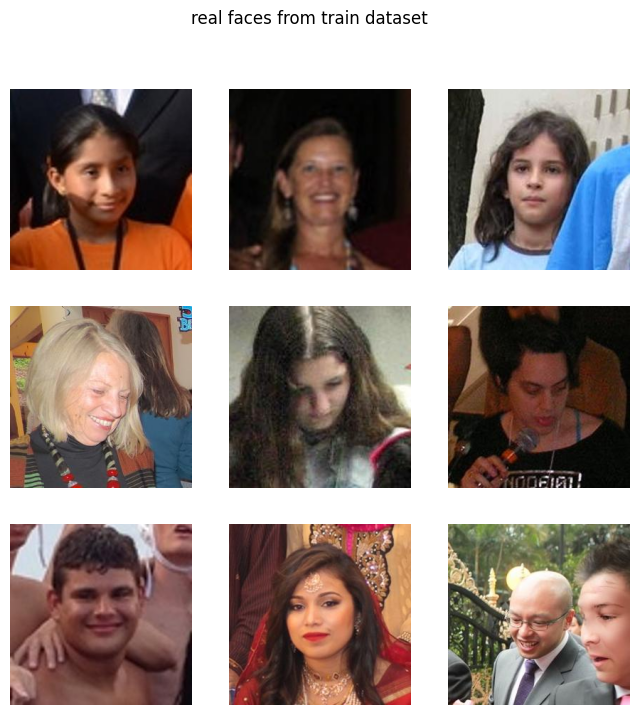

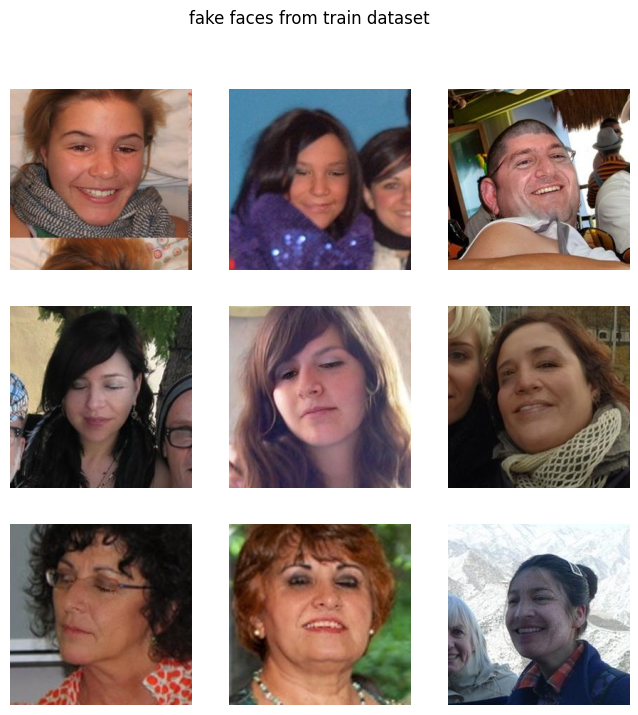

In [65]:
# Display real and fake images
plot_img(datapath, 'real').show()
plot_img(datapath, 'fake').show()

In [66]:
# Define input image shape
input_shape = (256,256,3)

In [67]:
# Define CNN model
model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))  # Normalize input
model.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(filters=1024, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.1))

/home/blaise/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [68]:
# Flatten the feature maps and add a dense layer for binary classification
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

In [69]:
# Display model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_8           │ (None, 256, 256, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 4, 4, 512)      │             

 Total params: 6,304,621 (24.05 MB)

 Trainable params: 6,300,551 (24.03 MB)

 Non-trainable params: 4,070 (15.90 KB)

In [70]:
# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.0001, weight_decay=1e-6) # edit
opt = Adam(learning_rate=0.0001, weight_decay=1e-6) # edit
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [71]:
# Define model checkpoint to save the best model
filepath = "saved-final-model.keras" # edit
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [72]:
# Define training steps
train_steps = 80000 // 64
valid_steps = 5000 // 64

In [92]:
# Train the model for 4 epochs
history = model.fit( # edit
    train_flow,
    epochs=20,
    callbacks=callbacks_list,
    steps_per_epoch=train_steps,
    validation_data=valid_flow,
    validation_steps=valid_steps
)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9675 - loss: 0.0818
Epoch 1: val_accuracy improved from 0.92668 to 0.94732, saving model to saved-final-model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 370s 296ms/step - accuracy: 0.9675 - loss: 0.0818 - val_accuracy: 0.9473 - val_loss: 0.1492
Epoch 2/20
 938/1250 ━━━━━━━━━━━━━━━━━━━━ 1:17 248ms/step - accuracy: 0.9732 - loss: 0.0691

/home/blaise/anaconda3/envs/py310/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.94732
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 277s 221ms/step - accuracy: 0.9732 - loss: 0.0687 - val_accuracy: 0.9439 - val_loss: 0.1575
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9755 - loss: 0.0627
Epoch 3: val_accuracy improved from 0.94732 to 0.94792, saving model to saved-final-model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 354s 283ms/step - accuracy: 0.9755 - loss: 0.0627 - val_accuracy: 0.9479 - val_loss: 0.1562
Epoch 4/20
 938/1250 ━━━━━━━━━━━━━━━━━━━━ 1:17 248ms/step - accuracy: 0.9794 - loss: 0.0515

2025-02-20 15:16:02.333786: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 4: val_accuracy did not improve from 0.94792
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 267s 213ms/step - accuracy: 0.9793 - loss: 0.0519 - val_accuracy: 0.9393 - val_loss: 0.1938
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9806 - loss: 0.0491
Epoch 5: val_accuracy improved from 0.94792 to 0.95212, saving model to saved-final-model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 343s 274ms/step - accuracy: 0.9806 - loss: 0.0491 - val_accuracy: 0.9521 - val_loss: 0.1537
Epoch 6/20
 938/1250 ━━━━━━━━━━━━━━━━━━━━ 1:29 287ms/step - accuracy: 0.9838 - loss: 0.0427
Epoch 6: val_accuracy did not improve from 0.95212
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 293s 234ms/step - accuracy: 0.9836 - loss: 0.0431 - val_accuracy: 0.9337 - val_loss: 0.2105
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9842 - loss: 0.0407
Epoch 7: val_accuracy improved from 0.95212 to 0.95733, saving model to saved-final-model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 372s 297ms/step - accuracy: 0.984

2025-02-20 16:17:36.296380: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 264s 211ms/step - accuracy: 0.9924 - loss: 0.0201 - val_accuracy: 0.9607 - val_loss: 0.1457
Epoch 17/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9930 - loss: 0.0189
Epoch 17: val_accuracy did not improve from 0.96075
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 318s 254ms/step - accuracy: 0.9930 - loss: 0.0189 - val_accuracy: 0.9573 - val_loss: 0.1665
Epoch 18/20
 938/1250 ━━━━━━━━━━━━━━━━━━━━ 1:14 238ms/step - accuracy: 0.9922 - loss: 0.0199
Epoch 18: val_accuracy did not improve from 0.96075
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 244s 195ms/step - accuracy: 0.9923 - loss: 0.0198 - val_accuracy: 0.9531 - val_loss: 0.1617
Epoch 19/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9946 - loss: 0.0151
Epoch 19: val_accuracy did not improve from 0.96075
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 322s 257ms/step - accuracy: 0.9946 - loss: 0.0151 - val_accuracy: 0.9563 - val_loss: 0.1687
Epoch 20/20
 938/1250 ━━━━━━━━━━━━━━━━━━━━ 1:14 239ms/step - accuracy: 0.9936

In [108]:
# Train the model for 2 more epochs
history = model.fit( # edit
    train_flow,
    epochs=20,
    callbacks=callbacks_list,
    steps_per_epoch=train_steps,
    validation_data=valid_flow,
    validation_steps=valid_steps
)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9942 - loss: 0.0157
Epoch 1: val_accuracy did not improve from 0.96075
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 320s 255ms/step - accuracy: 0.9942 - loss: 0.0157 - val_accuracy: 0.9553 - val_loss: 0.1700
Epoch 2/20
 938/1250 ━━━━━━━━━━━━━━━━━━━━ 1:13 236ms/step - accuracy: 0.9943 - loss: 0.0156

/home/blaise/anaconda3/envs/py310/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.96075 to 0.96454, saving model to saved-final-model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 242s 193ms/step - accuracy: 0.9942 - loss: 0.0158 - val_accuracy: 0.9645 - val_loss: 0.1272
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9948 - loss: 0.0140
Epoch 3: val_accuracy did not improve from 0.96454
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 313s 250ms/step - accuracy: 0.9948 - loss: 0.0140 - val_accuracy: 0.9577 - val_loss: 0.1855
Epoch 4/20
 938/1250 ━━━━━━━━━━━━━━━━━━━━ 1:12 234ms/step - accuracy: 0.9947 - loss: 0.0147
Epoch 4: val_accuracy did not improve from 0.96454
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 237s 190ms/step - accuracy: 0.9947 - loss: 0.0146 - val_accuracy: 0.9511 - val_loss: 0.1736
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9950 - loss: 0.0141
Epoch 5: val_accuracy improved from 0.96454 to 0.96735, saving model to saved-final-model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 315s 252ms/step - accuracy: 0.995

2025-02-20 17:06:46.808239: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4694390465014035689
2025-02-20 17:06:46.808309: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1467812946768556850



Epoch 6: val_accuracy did not improve from 0.96735
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 268s 215ms/step - accuracy: 0.9959 - loss: 0.0121 - val_accuracy: 0.9645 - val_loss: 0.1544
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9949 - loss: 0.0141
Epoch 7: val_accuracy did not improve from 0.96735
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 360s 287ms/step - accuracy: 0.9949 - loss: 0.0141 - val_accuracy: 0.9625 - val_loss: 0.1467
Epoch 8/20
 938/1250 ━━━━━━━━━━━━━━━━━━━━ 1:27 281ms/step - accuracy: 0.9962 - loss: 0.0115
Epoch 8: val_accuracy did not improve from 0.96735
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 275s 220ms/step - accuracy: 0.9960 - loss: 0.0119 - val_accuracy: 0.9561 - val_loss: 0.1694
Epoch 9/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9959 - loss: 0.0120
Epoch 9: val_accuracy did not improve from 0.96735
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 319s 255ms/step - accuracy: 0.9959 - loss: 0.0120 - val_accuracy: 0.9587 - val_loss: 0.1796
Epoch 10/20
 938/1250 ━━━━━━━━━

2025-02-20 17:26:39.561637: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4694390465014035689
2025-02-20 17:26:39.561712: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1467812946768556850



Epoch 10: val_accuracy did not improve from 0.96735
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 244s 195ms/step - accuracy: 0.9964 - loss: 0.0113 - val_accuracy: 0.9627 - val_loss: 0.1545
Epoch 11/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9960 - loss: 0.0114
Epoch 11: val_accuracy did not improve from 0.96735
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 315s 252ms/step - accuracy: 0.9960 - loss: 0.0114 - val_accuracy: 0.9623 - val_loss: 0.1672
Epoch 12/20
 938/1250 ━━━━━━━━━━━━━━━━━━━━ 1:14 238ms/step - accuracy: 0.9962 - loss: 0.0097
Epoch 12: val_accuracy did not improve from 0.96735
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 240s 192ms/step - accuracy: 0.9962 - loss: 0.0098 - val_accuracy: 0.9649 - val_loss: 0.1422
Epoch 13/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9958 - loss: 0.0125
Epoch 13: val_accuracy improved from 0.96735 to 0.96775, saving model to saved-final-model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 322s 258ms/step - accuracy: 0.9958 - loss: 0.0125 - val_accuracy: 0.967

2025-02-20 17:56:35.096702: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4694390465014035689
2025-02-20 17:56:35.096776: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1467812946768556850


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9961 - loss: 0.0113
Epoch 17: val_accuracy did not improve from 0.96775
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 317s 253ms/step - accuracy: 0.9961 - loss: 0.0113 - val_accuracy: 0.9621 - val_loss: 0.1485
Epoch 18/20
 938/1250 ━━━━━━━━━━━━━━━━━━━━ 1:13 237ms/step - accuracy: 0.9966 - loss: 0.0094
Epoch 18: val_accuracy did not improve from 0.96775
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 240s 192ms/step - accuracy: 0.9966 - loss: 0.0096 - val_accuracy: 0.9617 - val_loss: 0.1527
Epoch 19/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9968 - loss: 0.0090
Epoch 19: val_accuracy did not improve from 0.96775
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 321s 257ms/step - accuracy: 0.9968 - loss: 0.0090 - val_accuracy: 0.9557 - val_loss: 0.2069
Epoch 20/20
 938/1250 ━━━━━━━━━━━━━━━━━━━━ 1:14 240ms/step - accuracy: 0.9979 - loss: 0.0074
Epoch 20: val_accuracy improved from 0.96775 to 0.96835, saving model to saved-final-model.keras
1250/1250 ━━━━━━━━━━━━

In [109]:
# Save the final trained model
model.save("saved-final-model-256.keras") # edit

In [110]:
# Extract training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [111]:
# Function to plot loss
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [112]:
# Function to plot accuracy
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

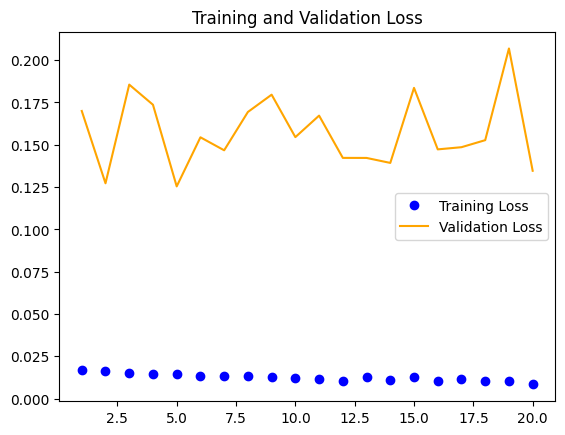

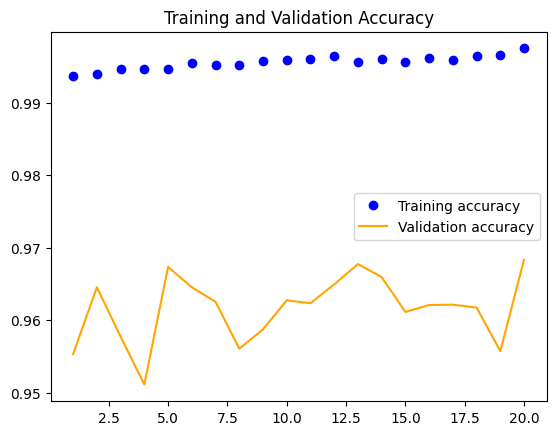

In [113]:
# Plot loss and accuracy
plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

In [114]:
# Predict on test data
y_pred = model.predict(test_flow)
y_test = test_flow.classes

10905/10905 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step


In [115]:
from sklearn.metrics import confusion_matrix # edit
# Compute confusion matrix
results = confusion_matrix(y_test, y_pred > 0.5)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in results.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in results.flatten()/np.sum(results)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

Text(0.5, 23.52222222222222, 'Predicted label')

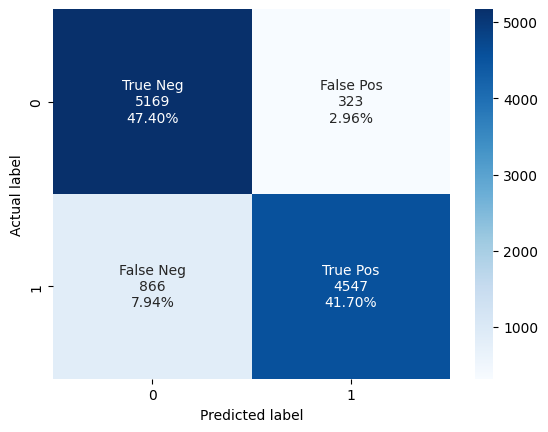

In [116]:
# Plot confusion matrix heatmap
sns.heatmap(results, annot=labels, fmt='', cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [117]:
from sklearn.metrics import accuracy_score # edit
from sklearn.metrics import classification_report # edit
import sklearn.metrics as metrics # edit
# Print evaluation metrics
print('Accuracy Score:', accuracy_score(y_test, y_pred > 0.5))
print('Report:')
print(classification_report(y_test, y_pred > 0.5))
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))

Accuracy Score: 0.8909674461256304
Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      5492
           1       0.93      0.84      0.88      5413

    accuracy                           0.89     10905
   macro avg       0.90      0.89      0.89     10905
weighted avg       0.89      0.89      0.89     10905

ROC-AUC Score: 0.9700724692477136


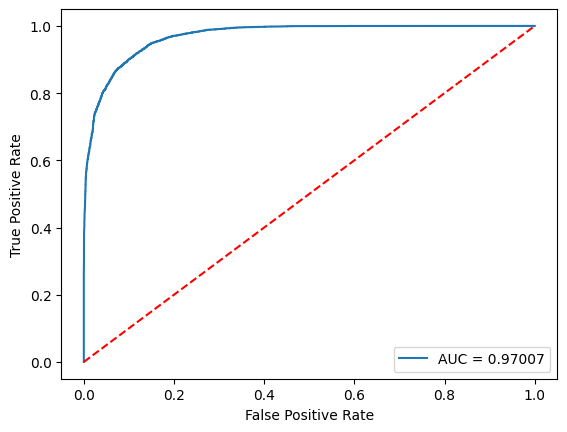

In [118]:
# Plot ROC curve
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label=f'AUC = {metrics.auc(fpr, tpr):.5f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [119]:
print("Number of filenames:", len(test_flow.filenames))

Number of filenames: 10905


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Text(0.5, 1.0, 'Predicted by the model as REAL, actually is REAL')

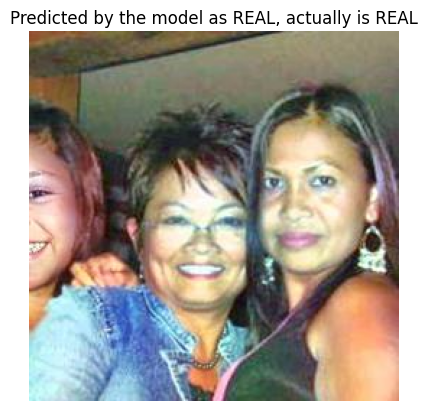

In [120]:
i = np.random.randint(len(test_flow.filenames))
datasetpath = test_flow.filenames[i]
imgpath = datapath+'test/'+datasetpath
plt.imshow(mpimg.imread(imgpath))
plt.axis('off')

if test_flow.classes[i] == 0:
    actual = "FAKE"
else:
    actual = "REAL"  
if model.predict(test_flow[i][0])[0][0]<0.5:
    prediction = "FAKE"
else:
    prediction = "REAL"

plt.title(f"Predicted by the model as {prediction}, actually is {actual}")

In [121]:
def predict_img_class():
    # Adjust random index to stay within bounds of test_flow
    k = np.random.randint(len(test_flow))  # Use len(test_flow) instead of 20000
    gridx = 4
    gridy = 4
    fig, ax = plt.subplots(gridx, gridy, figsize=(14, 14))

    for j in range(gridx):
        for i in range(gridy):
            # Get actual class (FAKE or REAL)
            if test_flow.classes[k] == 0:
                actual = "FAKE"
            else:
                actual = "REAL"  
                
            # Get prediction from model
            if model.predict(test_flow[k][0])[0][0] < 0.5:
                prediction = "FAKE"
            else:
                prediction = "REAL"
                
            # Load image
            datasetpath = test_flow.filenames[k]
            imgpath = datapath + 'test/' + datasetpath
            img = load_img(imgpath)          
            
            # Display image with prediction and actual label
            ax[j, i].imshow(img)
            ax[j, i].set_title(f"Predicted: {prediction}, Actual: {actual}", size=12)
            ax[j, i].axis('off')

            # Update k for the next image, staying within bounds
            k = np.random.randint(len(test_flow))  # Make sure it's within range of test_flow

    fig.suptitle('Testing the prediction on Test images', size=20)
    return plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


<module 'matplotlib.pyplot' from '/home/blaise/anaconda3/envs/py310/lib/python3.10/site-packages/matplotlib/pyplot.py'>

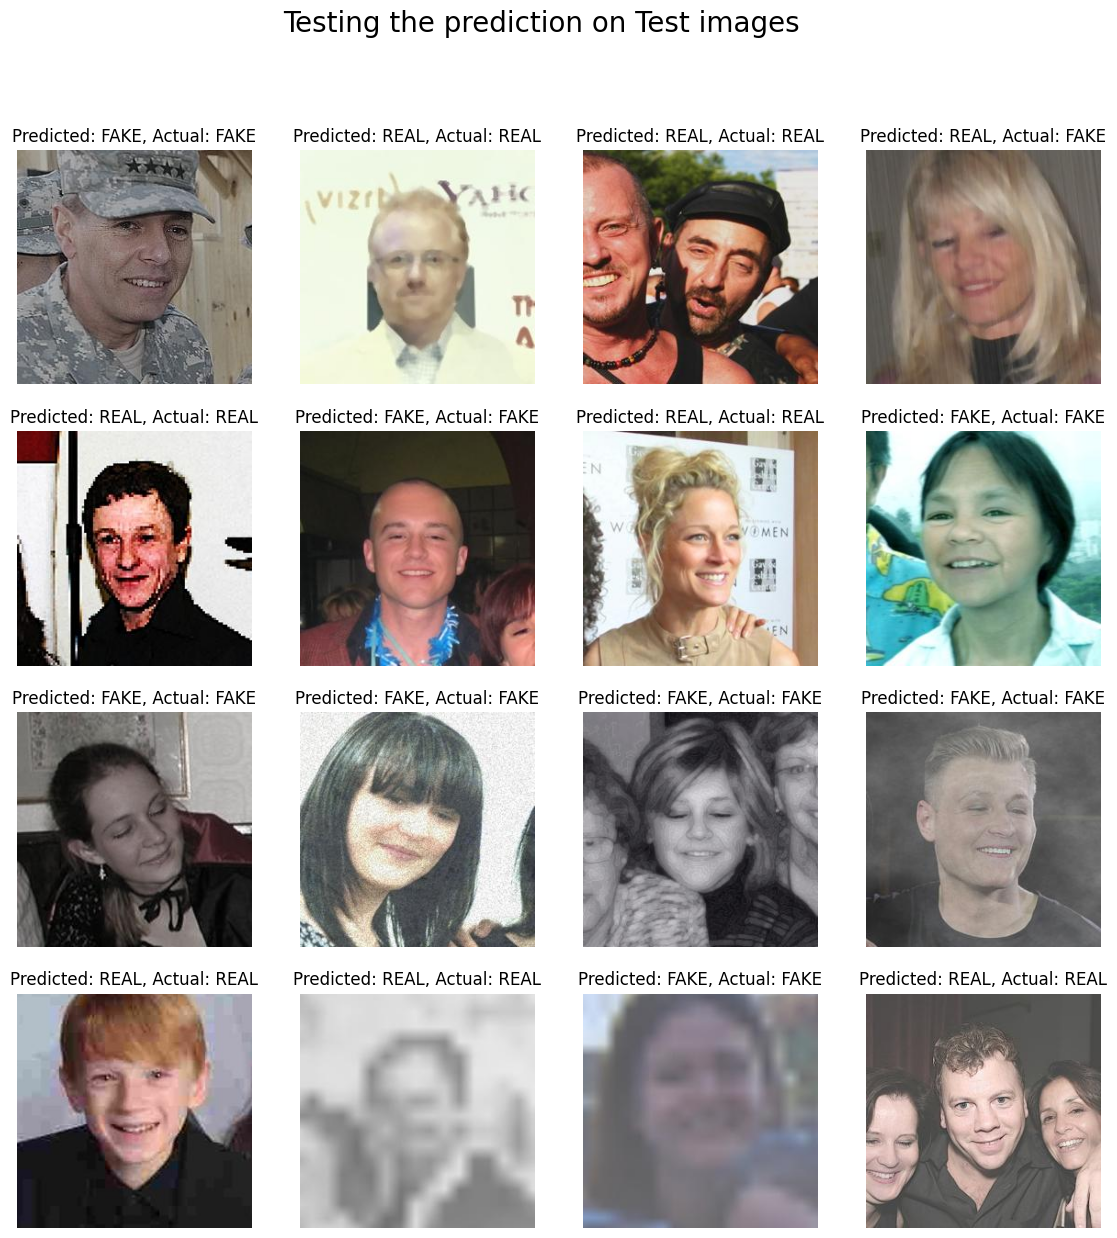

In [122]:
predict_img_class()

In [12]:
best_model = load_model("saved-final-model.keras")
final_model = load_model("saved-final-model-256.keras")

# Evaluate both
# best_model.evaluate(test_flow)
# final_model.evaluate(test_flow)

In [14]:
# best_model.summary()

In [38]:
########

In [9]:
from tensorflow.keras.models import load_model

model = load_model("best-model-140k.keras")

I0000 00:00:1740249343.613734     516 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1740249344.206201     516 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1740249344.206285     516 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1740249344.210023     516 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1740249344.210102     516 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [10]:

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_flow, batch_size=batch_size)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


/home/blaise/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1740249349.073287     632 service.cc:146] XLA service 0x7fdb6800fd20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740249349.073328     632 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-22 18:35:49.126449: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-22 18:35:49.349548: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


    6/10905 ━━━━━━━━━━━━━━━━━━━━ 5:04 28ms/step - accuracy: 0.0000e+00 - loss: 1.4280

I0000 00:00:1740249350.890861     632 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10905/10905 ━━━━━━━━━━━━━━━━━━━━ 144s 13ms/step - accuracy: 0.2467 - loss: 1.2806
Test Loss: 0.8556464314460754
Test Accuracy: 0.5374599099159241
